## BONE STRUCTURES EXTRACTION AND ENHANCEMENT IN CHEST RADIOGRAPHS VIA CNN TRAINED ON SYNTHETIC DATA

#### Abstract 

In this paper, we present a deep learning-based image pro-
cessing technique for extraction of bone structures in chest

radiographs using a U-Net FCNN. The U-Net was trained

to accomplish the task in a fully supervised setting. To cre-
ate the training image pairs, we employed simulated X-Ray

or Digitally Reconstructed Radiographs (DRR), derived from
664 CT scans belonging to the LIDC-IDRI dataset. Using
HU based segmentation of bone structures in the CT domain,
a synthetic 2D ”Bone x-ray” DRR is produced and used for
training the network. For the reconstruction loss, we utilize
two loss functions- L1 Loss and perceptual loss. Once the

bone structures are extracted, the original image can be en-
hanced by fusing the original input x-ray and the synthesized

“Bone X-ray”. We show that our enhancement technique is
applicable to real x-ray data, and display our results on the
NIH Chest X-Ray-14 dataset.

### Objetivo do notebook: Recriar o sistema de extração de estruturas osseas de uma imagem de raio x

A medida que os raios-X se propagam através da matéria, sua energia diminui. 
Esta atenuação na energia do raio-X incidente depende da distância viajada e no coeficiente de atenuação. 
Este relacionamento é expresso pela lei de [Beer Lambert](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law), onde I0 é o incidente
feixe, I é a intensidade após viajar uma distância x e A é
o coeficiente de atenuação:

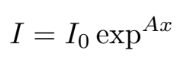

A fim de simular o processo de geração de raios-X, o calculo do coeficiente de atenuação é necessário para cada voxel

#### Registrando valores de constantes utilizados no artigo original

In [1]:
ATTENUATION_COEFFICIENT_OF_WATER = 0.2
BETA_PARAMETER_OF_ATTENUATION = 0.02
BONE_VOXELS_MAX_RANGE = 700
BONE_VOXELS_MIN_RANGE = 300
NON_BONE_VOXELS_VALUE = -1024
# Pixel size is typically between 0.5 and 1.5 mm. Let's choose 1 for simplicity
PIXEL_SIZE = 1

#### importando dependencias necessarias

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylidc as pl
import math
from PIL import Image
import numpy as np
from functools import lru_cache
import cv2
import scipy

Primeiro, precisamos estabelecer o processo de geração de imagens de CXR. Para isso vamos usar a base de dados [LIDC-IDRI](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI) a qual possui dados de tomografias.
Precisamo primeiro carregar as imagens. Por simplicidade iremos carregar apenas uma.(acessar https://pylidc.github.io/ para mais informações)

In [5]:
pid = 'LIDC-IDRI-0071'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

O objeto scan possui diversos métodos e atributos. O método de interesse é o 'load_all_dicom_images' o qual ira retornar uma lista de imagens. Cada imagem é uma parte da varredura em profundidade feita pela tomografia. Nesse sentido, seremos capazes de determinar o Housfield unit de cada imagem segundo a função definida a seguir:

In [9]:
def get_pixels_hu(loaded_dicom_images):
    image = np.stack([s.pixel_array for s in loaded_dicom_images])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = loaded_dicom_images[0].RescaleIntercept
    slope = loaded_dicom_images[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Agora precisamos carregar todas as imagens e calcular os valores de HU

In [14]:
images = scan.load_all_dicom_images()
hounsfield_unit_matrix = get_pixels_hu(images)

Loading dicom files ... This may take a moment.


In [15]:
hounsfield_unit_matrix.shape

(261, 512, 512)

Podemos rapidamente fazer um levantamento da distribuição das unidades para termos uma noção melhor da imagem que estamos lidando.

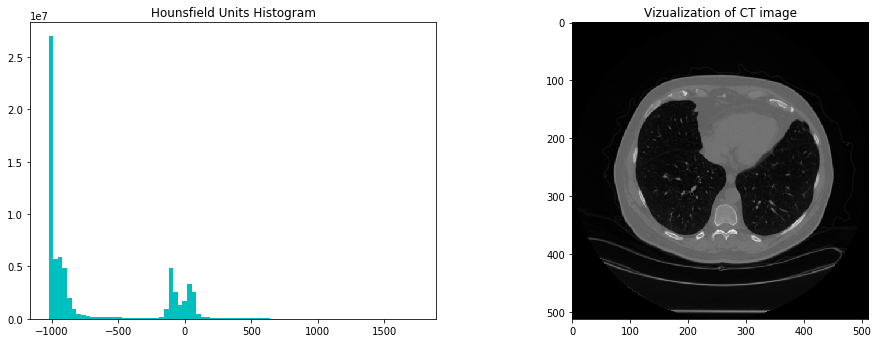

In [40]:
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(2,2,1)
ax1.hist(hounsfield_unit_matrix.flatten(), bins=80, color='c')
ax1.set_title('Hounsfield Units Histogram')
ax1.xaxis.set_label("Hounsfield Units (HU)")
ax1.yaxis.set_label("Frequency")
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Vizualization of CT image')
ax2.imshow(hounsfield_unit_matrix[80], cmap=plt.cm.gray)
plt.show()

Com essas informações em mãos, podemos agora obter a matriz de atenuação média a qual será utilizada para, a partir da equação de beer lambert, gerar as imagens de CXR.

In [49]:
def get_everage_attenuation_matrix(hu_mtrix_values):
    # using cache to avoid recalculations
    @lru_cache(maxsize=256) 
    def get_attenuation_coeficient(HU):
        #The air attenuation coefficient was considered zero for simplicity. And the water attenuation coefficient was previously defined.
        return (((HU/1000.0)*ATTENUATION_COEFFICIENT_OF_WATER)-ATTENUATION_COEFFICIENT_OF_WATER)
    atenuation_matrix = np.zeros((hu_mtrix_values.shape[2],hu_mtrix_values.shape[0]))
    for z_axes in range(hu_mtrix_values.shape[0]):
        for y_axes in range(hu_mtrix_values.shape[2]):
            average = 0
            # calculate everage cross y axis
            for x_axes in range(hu_mtrix_values.shape[1]):
                average += (get_attenuation_coeficient(hu_mtrix_values[z_axes,x_axes,y_axes])/hu_mtrix_values.shape[2])
            atenuation_matrix[y_axes,z_axes] = average
    return atenuation_matrix

Calculando a matriz de atenuação média:

In [50]:
everage_attenuation_matrix = get_everage_attenuation_matrix(hounsfield_unit_matrix)
everage_attenuation_matrix.shape

(512, 261)

Agora, com a matriz de atenuação em mãos, podemos gerar a imagem de raio-x

In [69]:
def get_DDR_image(attenuation_coeficient_matrix):
    @lru_cache(maxsize=256)
    def get_pixel_value(atenuation):
        return math.exp(BETA_PARAMETER_OF_ATTENUATION*atenuation)
    matrix = np.zeros((attenuation_coeficient_matrix.shape[0],attenuation_coeficient_matrix.shape[1]))
    for y_axes in range(attenuation_coeficient_matrix.shape[0]):
        for z_axes in range(attenuation_coeficient_matrix.shape[1]):
            matrix[y_axes,z_axes] = get_pixel_value(attenuation_coeficient_matrix[y_axes,z_axes])
    return np.rot90(matrix,k=1)

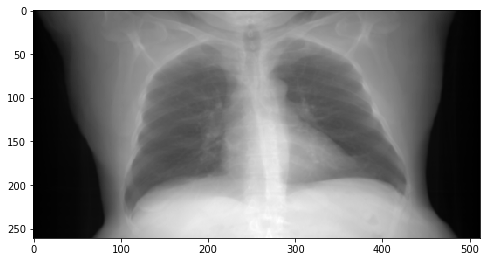

In [70]:
CXR_image = get_DDR_image(everage_attenuation_matrix)
plt.figure(figsize = (8,8))
plt.imshow(CXR_image, cmap=plt.cm.gray,interpolation='nearest')

Podemos agora, gerar a mesma imagem, porêm, dando relevância às extruturas osseas. Considerando ossos na faixa de 300 à 700 HU, Podemos redefinir a função da seguinte maneira:

In [87]:
def get_pixels_hu_extract_bones(loaded_dicom_images):
    image = np.stack([s.pixel_array for s in loaded_dicom_images])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = loaded_dicom_images[0].RescaleIntercept
    slope = loaded_dicom_images[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    hu_matrix = np.array(image, dtype=np.int16)
    hu_matrix[hu_matrix < 300] = -1024
    hu_matrix[hu_matrix > 700] = -1024
    return hu_matrix

In [88]:
hounsfield_unit_matrix_bones = get_pixels_hu_extract_bones(images)

In [89]:
everage_attenuation_matrix_bones = get_everage_attenuation_matrix(hounsfield_unit_matrix_bones)
everage_attenuation_matrix_bones.shape

(512, 261)

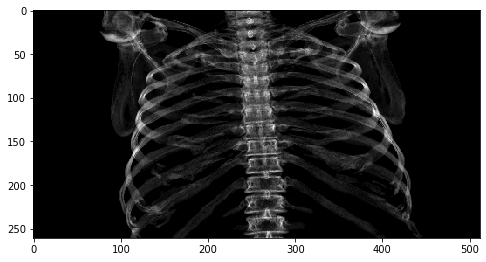

In [90]:
CXR_image_bones = get_DDR_image(everage_attenuation_matrix_bones)
plt.figure(figsize = (8,8))
plt.imshow(CXR_image_bones, cmap=plt.cm.gray, interpolation='nearest')

Para visualizar melhor a imagem:

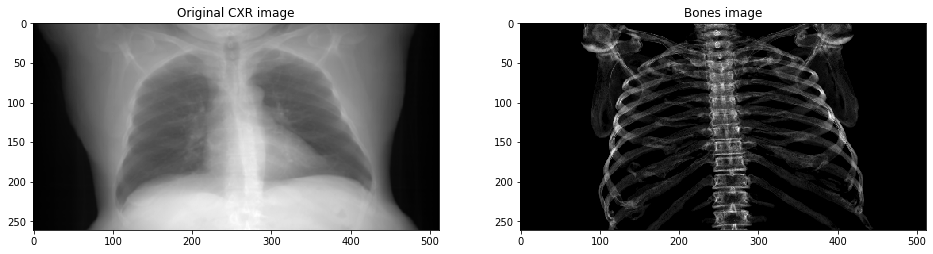

In [91]:
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(CXR_image, cmap=plt.cm.gray,interpolation='nearest')
ax1.set_title('Original CXR image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(CXR_image_bones, cmap=plt.cm.gray, interpolation='nearest')
ax2.set_title('Bones image')
plt.show()

Vamos fazer o resize das imagens e comparar a imagem do conjunto da base do projeto tb latente com as imagens geradas

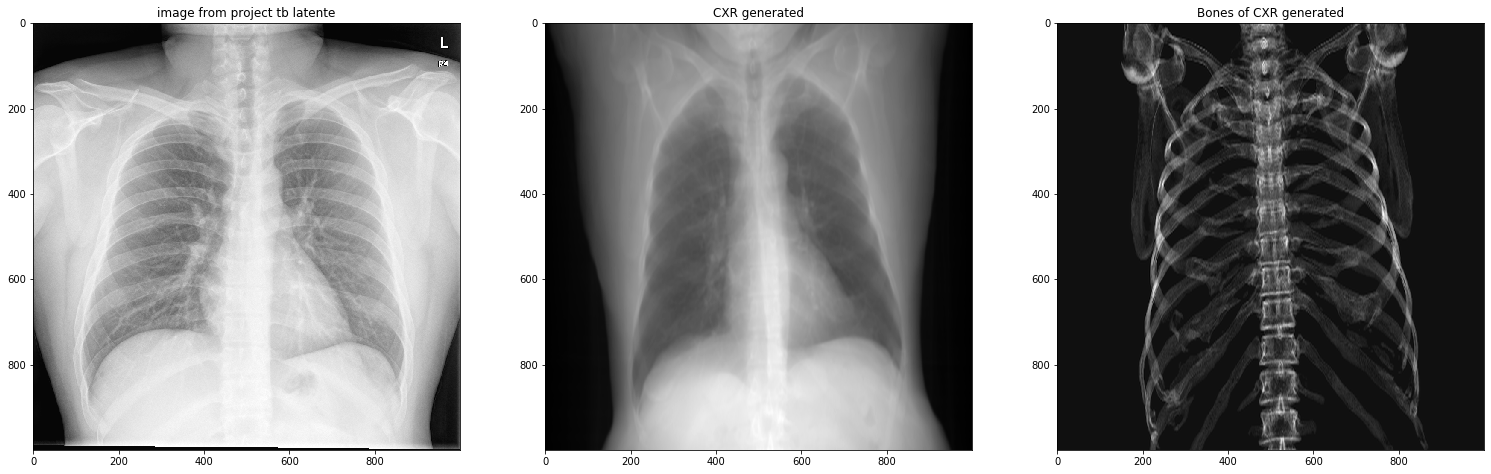

In [156]:
image = Image.open('/home/patrick.braz/Documents/pessoal/CHNCXR_0019_0.png')
image = image.resize((1000,1000),Image.ANTIALIAS)
CXR_image_resized = cv2.resize(scipy.ndimage.zoom(
    CXR_image,zoom=2,order=3),(1000,1000),interpolation = cv2.INTER_CUBIC)
CXR_image_bones_resized = cv2.resize(scipy.ndimage.zoom(
    CXR_image_bones,zoom=2,order=3),(1000,1000),interpolation = cv2.INTER_CUBIC)
fig = plt.figure(figsize = (26,12))
(ax1,ax2,ax3) = fig.subplots(1, 3)
# ax1 = fig.add_subplot(2,1,1)
ax1.imshow(image,cmap=plt.cm.gray, interpolation='nearest')
ax1.set_title('image from project tb latente')
# ax2 = fig.add_subplot(2,2,2)
ax2.imshow(CXR_image_resized, cmap=plt.cm.gray, interpolation='nearest')
ax2.set_title('CXR generated')
# ax3 = fig.add_subplot(2,2,3)
ax3.imshow(CXR_image_bones_resized, cmap=plt.cm.gray, interpolation='nearest')
ax3.set_title('Bones of CXR generated')
plt.show()

## Gerando a base de dados para treino